In [1]:
## Creating Data
import numpy as np
import matplotlib.pyplot as plt
def get_spiral():
    # Idea: radius -> low...high
    #           (don't start at 0, otherwise points will be "mushed" at origin)
    #       angle = low...high proportional to radius
    #               [0, 2pi/6, 4pi/6, ..., 10pi/6] --> [pi/2, pi/3 + pi/2, ..., ]
    # x = rcos(theta), y = rsin(theta) as usual

    radius = np.linspace(1, 10, 1000)
    thetas = np.empty((6, 1000))
    for i in range(6):
        start_angle = np.pi*i / 3.0
        end_angle = start_angle + np.pi / 2
        points = np.linspace(start_angle, end_angle, 1000)
        thetas[i] = points

    # convert into cartesian coordinates
    x1 = np.empty((6, 1000))
    x2 = np.empty((6, 1000))
    for i in range(6):
        x1[i] = radius * np.cos(thetas[i])
        x2[i] = radius * np.sin(thetas[i])

    # inputs
    X = np.empty((6000, 2))
    X[:,0] = x1.flatten()
    X[:,1] = x2.flatten()

    # add noise
    X += np.random.randn(6000, 2)*0.5

    # targets
    Y = np.array([0]*1000 + [1]*1000 + [2]*1000 + [0]*1000 + [3]*1000 + [2]*1000)
    return X, Y

X,y=get_spiral()

plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

## Processing the Data

def one_hot_encoder(X):
    N=X.shape[0]
    K=len(np.unique(X))
    Z=np.zeros((N,K))
    for i in range(N):
        c=int(X[i])
        Z[i,c]=1
    return Z
y_i=one_hot_encoder(y)

def standardize(X):
    stds=X.std(axis=0)
    means=X.mean(axis=0)
    X=(X-means)/stds
    return X,means,stds

X_s,m,s=standardize(X)

def train_test_split(X,y,size=0.8,rs=None):
    N=len(X)
    np.random.seed(rs)
    tr_i=np.random.choice(N,int(size*N),replace=False)
    t_i=[i for i in range(N) if i not in tr_i]
    X_train=X[tr_i]
    y_train=y[tr_i]
    X_test=X[t_i]
    y_test=y[t_i]
    return X_train,y_train,X_test,y_test
X_train,y_train,X_test,y_test=train_test_split(X_s,y,size=0.9,rs=20)

X_train=X_train.astype(np.float32)
y_train=y_train.astype(np.float32)
X_test=X_test.astype(np.float32)
y_test=y_test.astype(np.float32)

<Figure size 640x480 with 1 Axes>

In [2]:
import torch
from torch.optim import RMSprop
from torch.autograd import Variable

In [3]:
_,D=X_train.shape
K=len(set(y))

In [4]:
model=torch.nn.Sequential()

In [5]:
model.add_module('x0',torch.nn.Linear(D,500))
model.add_module('x',torch.nn.ReLU())
model.add_module('x1',torch.nn.Linear(500,300))
model.add_module('xa',torch.nn.ReLU())
model.add_module('x2',torch.nn.Linear(300,K))

# Similar to tensorflow no softmax layer
# model.add_module('x',torch.nn.Softmax())




In [6]:
loss=torch.nn.CrossEntropyLoss(reduction='mean')

In [7]:
optimizer=RMSprop(model.parameters(),lr=0.01,momentum=0.95)

In [8]:
def train(model,loss,optimizer,inputs,labels):
    inputs=Variable(inputs,requires_grad=False)
    labels=Variable(labels,requires_grad=False)
    
    # rest the gradient
    optimizer.zero_grad()
    
    # Forward
    logits=model.forward(inputs) 
    outputs=loss.forward(logits,labels)
    
    # BackProp
    outputs.backward()
    
    # Update Variables
    optimizer.step()
    
    return outputs.item()
    
    

In [9]:
def predict(inputs,model):
#     print(inputs)
    inputs=Variable(inputs,requires_grad=False)
    logits=model.forward(inputs)
    return logits.data.numpy().argmax(axis=1)

In [10]:
def fit(X,y,epochs=100,batch_size=290,random_state=None,fig=True):
    X_t,y_t,X_v,y_v=train_test_split(X,y,size=0.9,rs=random_state)
    X_t=torch.from_numpy(X_t).float()
    y_t=torch.from_numpy(y_t).long()
    X_v=torch.from_numpy(X_v).float()
    c_t=[]
    c_v=[]
    cl_t=[]
    cl_v=[]
    N=X_t.shape[0]
    n_batch=int(np.ceil(N/batch_size))
    for i in range(epochs):
        for j in range(n_batch):
            x=X_t[j*batch_size:(j*batch_size+batch_size)]
            yb=y_t[j*batch_size:j*batch_size+batch_size]
            cost = train(model, loss, optimizer, x, yb)
            c_t.append(cost)
            logits=model.forward(Variable(X_v,requires_grad=False))
            cost=loss.forward(logits,Variable(torch.from_numpy(y_v).long(),requires_grad=False))
            c_v.append(cost)
            cl_t.append(np.mean(yb.data.numpy() == predict(x,model)))               
            cl_v.append(np.mean(y_v == predict(X_v,model)))
        if i%1==0:
            print('Epoch {0} Train C: {1} Cl: {2} Test C:{3} Cl:{4}'.format(i,c_t[i],cl_t[i],c_v[i],cl_v[i]))
    if fig==True:
        plt.plot(c_t,label='Train Cost')        
        plt.plot(c_v,label='Test Cost')
        plt.legend()
        plt.show()
        plt.plot(cl_t,label='Train Classification')
        plt.plot(cl_v,label='Test Classification')
        plt.legend()
        plt.show()
            

Epoch 0 Train C: 1.3727095127105713 Cl: 0.35517241379310344 Test C:58.52114486694336 Cl:0.34814814814814815
Epoch 1 Train C: 56.97124099731445 Cl: 0.33793103448275863 Test C:197.91122436523438 Cl:0.31666666666666665
Epoch 2 Train C: 172.84066772460938 Cl: 0.3103448275862069 Test C:280.0531311035156 Cl:0.32592592592592595
Epoch 3 Train C: 258.8616638183594 Cl: 0.31724137931034485 Test C:169.65631103515625 Cl:0.3351851851851852
Epoch 4 Train C: 157.92111206054688 Cl: 0.02413793103448276 Test C:165.71800231933594 Cl:0.012962962962962963
Epoch 5 Train C: 153.02920532226562 Cl: 0.38275862068965516 Test C:141.33909606933594 Cl:0.31666666666666665
Epoch 6 Train C: 130.42190551757812 Cl: 0.31724137931034485 Test C:97.1428451538086 Cl:0.32592592592592595
Epoch 7 Train C: 112.03529357910156 Cl: 0.4413793103448276 Test C:59.87803268432617 Cl:0.45555555555555555
Epoch 8 Train C: 59.43079376220703 Cl: 0.5206896551724138 Test C:58.93544006347656 Cl:0.4462962962962963
Epoch 9 Train C: 63.471523284912

Epoch 78 Train C: 6.419244289398193 Cl: 0.9689655172413794 Test C:2.1126041412353516 Cl:0.9666666666666667
Epoch 79 Train C: 7.860829830169678 Cl: 0.9827586206896551 Test C:2.144615888595581 Cl:0.9685185185185186
Epoch 80 Train C: 3.597111463546753 Cl: 0.9586206896551724 Test C:2.1624882221221924 Cl:0.9722222222222222
Epoch 81 Train C: 0.7545262575149536 Cl: 0.9793103448275862 Test C:7.001181602478027 Cl:0.9666666666666667
Epoch 82 Train C: 3.0311427116394043 Cl: 0.9517241379310345 Test C:15.859899520874023 Cl:0.9592592592592593
Epoch 83 Train C: 24.213539123535156 Cl: 0.9517241379310345 Test C:5.3419928550720215 Cl:0.9611111111111111
Epoch 84 Train C: 11.232309341430664 Cl: 0.9545454545454546 Test C:2.367525577545166 Cl:0.9685185185185186
Epoch 85 Train C: 3.0997421741485596 Cl: 0.9724137931034482 Test C:2.4243323802948 Cl:0.9666666666666667
Epoch 86 Train C: 2.255415439605713 Cl: 0.9793103448275862 Test C:2.612726926803589 Cl:0.9648148148148148
Epoch 87 Train C: 2.829024314880371 Cl:

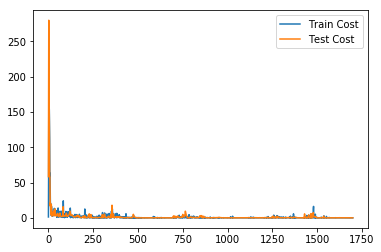

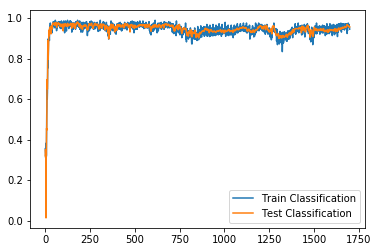

In [11]:
fit(X_train,y_train)